Eivind: LSTM, XGB // NN, LR

In [133]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf  # module to run ordinary least squares analysis
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score  # Import regression metrics

import warnings
warnings.filterwarnings("ignore")


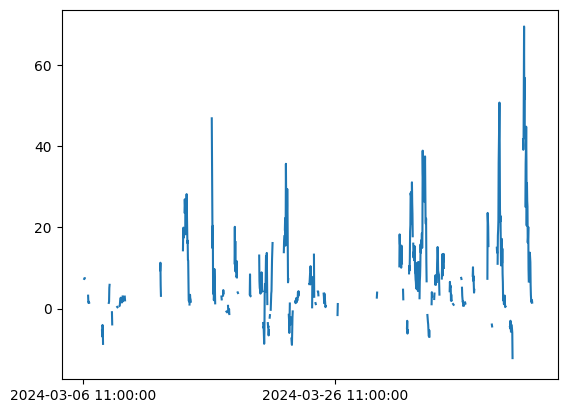

In [134]:
# Real data
# Load and prepare the data
df = pd.read_csv("../data/Tuddal_data.csv", na_values=np.nan)

df["albedo"] = df['R_SW_in'] / df['R_LW_out_corr']

# Define features and target variable
features = ["wind_speed", "max_wind_speed", "R_SW_in", "precip_int_h_D", "albedo",
        "air_temperature", "wind_dir", "specific_humidity",
        "air_pressure", "precip_int_h_D", 
        "FC1DRIFTsum_99_99_1_1_1", "FC2DRIFTsum_99_99_1_1_1"]

df_cont = df.dropna(subset=['LE_qc0']) 
df_cont = df.dropna(subset=features) 

y = df_cont["LE_qc0"] # filtered data
X = df_cont[features] # filtered data
t = df_cont['timestamp'] #filtered data
y2 = df["LE_qc0"] # non-filtered data
t2 = df['timestamp'] # non-filtered data

fig, ax = plt.subplots(1,1)

ax.plot(t2,y2)
ax.set_xticks(ax.get_xticks()[::960])

In [135]:
# Synthetic data 1 - Not in use
# Generating synthetic data
# Latent heat and the three variables with the highest R-squared when compared with latent heat in linear regression: 
# maximum wind speed (mws), incoming shortwave radiaton (sw_in) and albedo (alb)

# Current state: no covariance implemented between the data 

# Define column statistics based on the original dataset
num_rows = len(df)  # Choose the number of rows for the synthetic dataset
mean_value_le = np.mean(y) # mean of the latent heat data
std_dev_le = np.std(y) # std deviation of the latent heat data

mean_value_mws = np.mean(df_cont['max_wind_speed']) # mean of the max wind speed data
std_dev_mws = np.std(df_cont['max_wind_speed']) # std deviation of the max wind speed data

mean_value_sw_in = np.mean(df_cont['R_SW_in']) # mean of the shortwave in data
std_dev_sw_in = np.std(df_cont['R_SW_in']) # std deviation of the shortwave in data

mean_value_alb = np.mean(df_cont['albedo']) # mean of the albedo data
std_dev_alb = np.std(df_cont['albedo']) # std deviation of the albedo data

# Generate synthetic data
synthetic_le = np.random.normal(mean_value_le, std_dev_le, num_rows)
synthetic_mws = np.random.normal(mean_value_mws, std_dev_mws, num_rows)
synthetic_sw_in = np.random.normal(mean_value_sw_in, std_dev_sw_in, num_rows)
synthetic_alb = np.random.normal(mean_value_alb, std_dev_alb, num_rows)

# Define means and covariance matrix
#mean = [50, 30]
#cov = [[1, 0.8], [0.8, 1]]  # High correlation between two variables
#synthetic_correlated_data = np.random.multivariate_normal(mean, cov, num_rows)

# Separate the columns
#synthetic_column_1, synthetic_column_2 = synthetic_correlated_data[:, 0], synthetic_correlated_data[:, 1]

# Combining columns into a dataframe
synthetic_df = pd.DataFrame({
    'LE_synthetic': synthetic_le,
    'mws_synthetic': synthetic_mws,
    'sw_in_synthetic': synthetic_sw_in,
    'albedo_synthetic': synthetic_alb,
})


                     temperature   humidity  wind_speed  precipitation  \
2023-09-01 00:00:00    13.754423  87.431628    8.356672       0.814271   
2023-09-01 00:30:00     8.435496  46.082151    5.216571       1.628958   
2023-09-01 01:00:00    13.912289  68.504110    6.502374       1.039952   
2023-09-01 01:30:00     7.338419  71.581116    6.471064       0.866984   
2023-09-01 02:00:00    11.730720  65.370742    7.206022       0.186083   

                     solar_radiation  latent_heat  
2023-09-01 00:00:00              0.0    54.977385  
2023-09-01 00:30:00              0.0    29.418793  
2023-09-01 01:00:00              0.0    45.735481  
2023-09-01 01:30:00              0.0    41.572087  
2023-09-01 02:00:00              0.0    42.851492  
        temperature      humidity    wind_speed  precipitation  \
count  17521.000000  17521.000000  17521.000000   17521.000000   
mean      20.309155     59.978211      5.012520       0.032533   
std        7.835099     14.129814      1.4232

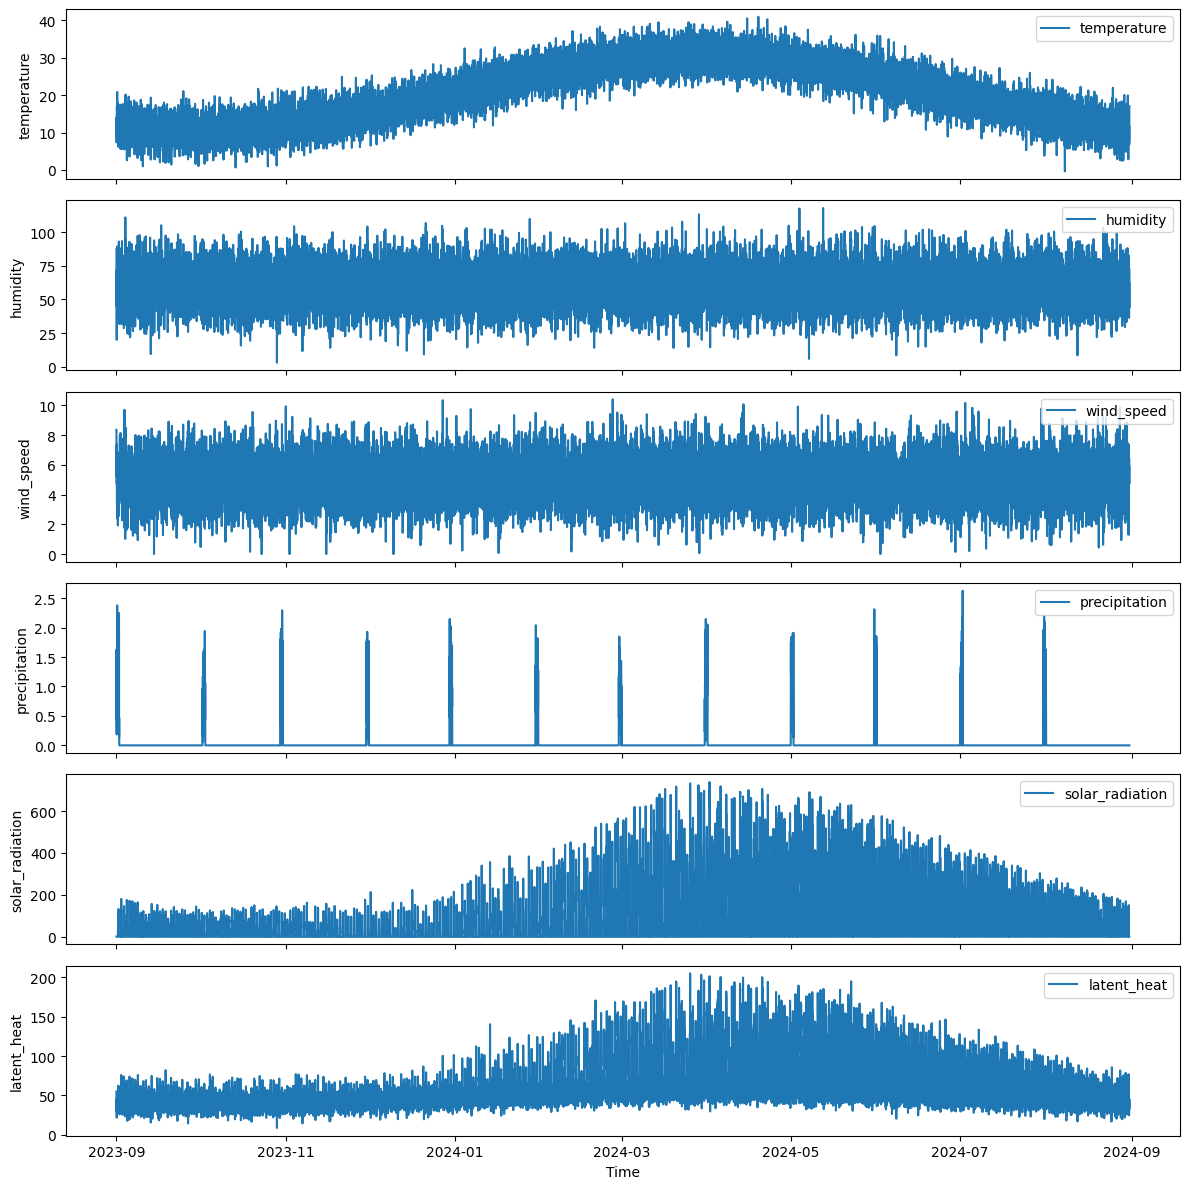

In [136]:
# Synthetic data 2 - In use

# User-defined parameters
params = {
    'latitude': 60,
    'start_date': '2023-09-01',
    'end_date': '2024-08-31',
    'frequency': '30min',
    'feature_means': {
        'temperature': 20,  # Mean temperature in degrees Celsius
        'humidity': 60,  # Mean relative humidity in %
        'wind_speed': 5,  # Mean wind speed in m/s
        'precipitation': 1  # Mean precipitation in mm
    },
    'feature_stds': {
        'temperature': 2,  # Std deviation for temperature
        'humidity': 10,  # Std deviation for humidity
        'wind_speed': 1,  # Std deviation for wind speed
        'precipitation': 0.5  # Std deviation for precipitation
    },
    'average_rainy_days_per_month': [10, 8, 10, 12, 15, 18, 20, 18, 15, 12, 10, 12],  # Average rainy days per month
    'rain_transition_probability': 0.7,  # Probability that a rainy day will be followed by another rainy day
    'seasonal_amplitude': 10,
    'diurnal_amplitude': 2,
    'latent_heat_noise': 0.5,
}

# Define functions
def solar_declination(day_of_year):
    return 23.44 * np.sin(np.radians(360 / 365.24 * (day_of_year - 81)))

def day_length(day_of_year, latitude):
    decl = solar_declination(day_of_year)
    latitude_rad = np.radians(latitude)
    decl_rad = np.radians(decl)
    cos_hour_angle = -np.tan(latitude_rad) * np.tan(decl_rad)
    hour_angle = np.arccos(np.clip(cos_hour_angle, -1, 1))
    day_length_hours = 2 * np.degrees(hour_angle) / 15
    return day_length_hours

def generate_rainy_days(num_days, avg_rainy_days, transition_probability):
    rain_days = np.zeros(num_days)
    actual_rainy_days = min(num_days, avg_rainy_days)
    initial_rain_days = np.random.choice(num_days, actual_rainy_days, replace=False)
    
    for i in initial_rain_days:
        rain_days[i] = 1
        j = i + 1
        while j < num_days and np.random.rand() < transition_probability:
            rain_days[j] = 1
            j += 1

    return rain_days

# Define time period and frequency
time_period = pd.date_range(start=params['start_date'], end=params['end_date'], freq=params['frequency'])
num_samples = len(time_period)
num_days = len(pd.date_range(start=params['start_date'], end=params['end_date'], freq='D'))

# Generate monthly rainy days
rainy_days = np.zeros(num_days)
for month in range(1, 13):
    days_in_month = len(pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-{month:02d}-01', freq='D') + pd.offsets.MonthEnd())
    monthly_rainy_days = generate_rainy_days(days_in_month, params['average_rainy_days_per_month'][month-1], params['rain_transition_probability'])
    start_day = pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-12-31', freq='D').dayofyear[0] - 1
    rainy_days[start_day:start_day+days_in_month] = monthly_rainy_days

rainy_hours = np.repeat(rainy_days, 48)[:num_samples]  # 48 periods per day for half-hourly data

# Generate features based on user-defined means, stds, and additional noise
features = {}
for feature in params['feature_means']:
    base = np.random.normal(loc=params['feature_means'][feature], scale=params['feature_stds'][feature], size=num_samples)
    seasonal_pattern = params['seasonal_amplitude'] * np.sin(2 * np.pi * time_period.dayofyear / 365)
    diurnal_pattern = params['diurnal_amplitude'] * np.sin(2 * np.pi * time_period.hour / 24)

    if feature == 'temperature':
        features[feature] = base + seasonal_pattern + diurnal_pattern
    else:
        features[feature] = base

# Solar radiation and cloudiness factor
latitude = params['latitude']
solar_radiation = np.zeros(num_samples)
cloudiness_factor = np.random.uniform(low=0, high=1, size=num_samples)  # Random cloudiness factor

for i in range(num_samples):
    day_of_year = time_period[i].dayofyear
    hour_of_day = time_period[i].hour + time_period[i].minute / 60.0
    day_length_hours = day_length(day_of_year, latitude)
    max_radiation = 450 + 300 * np.sin(2 * np.pi * (day_of_year / 365))  # Adjust according to seasonality
    
    if hour_of_day < (24 - day_length_hours) / 2 or hour_of_day > 24 - (24 - day_length_hours) / 2:
        radiation = 0  # No radiation outside of daylight hours
    else:
        hour_angle = (hour_of_day - 12) * 2 * np.pi / 24  # Convert time to hour angle in radians
        effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        reduction_factor = 0.7 if effective_cloudiness == 1 else 1 - effective_cloudiness
        radiation = max_radiation * max(0, np.sin(hour_angle)) * reduction_factor
    
    solar_radiation[i] = radiation

features['solar_radiation'] = solar_radiation
features_df = pd.DataFrame(features, index=time_period)

# Apply cloudiness and rain impact on temperature
temperature_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    hour_of_day = time_period[i].hour
    effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        
    # Temperature adjustment based on cloudiness and rain
    if effective_cloudiness > 0.5:  # Consider it cloudy if effective_cloudiness is greater than 0.5
        if hour_of_day >= 6 and hour_of_day <= 18:  # Cloudy during daytime
            if time_period[i].month in [6, 7, 8]:  # Summer months
                temperature_adjustment[i] = -2 * effective_cloudiness
            else:  # Other months
                temperature_adjustment[i] = 1 * effective_cloudiness
        else:  # Cloudy during nighttime
            temperature_adjustment[i] = 1.5 * effective_cloudiness
    
features_df['temperature'] += temperature_adjustment

# Apply rainy day impact on precipitation
precipitation_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    if rainy_hours[i] == 1:
        precipitation_adjustment[i] = np.random.normal(loc=params['feature_means']['precipitation'], scale=params['feature_stds']['precipitation'])

features_df['precipitation'] = precipitation_adjustment

# Add noise term to the other features
for feature in features:
    if feature not in ('precipitation', 'solar_radiation'):
        noise = np.random.normal(0, params['feature_stds'].get(feature, 1), num_samples)
        features_df[feature] += noise

# Clip values to ensure they do not go below zero
features_df['precipitation'] = np.clip(features_df['precipitation'], 0, None)
features_df['humidity'] = np.clip(features_df['humidity'], 0, None)
features_df['wind_speed'] = np.clip(features_df['wind_speed'], 0, None)

# Generate the target variable (latent heat) with additional noise term
noise = np.random.normal(0, 1, num_samples)
latent_heat = 0.8 * features_df['temperature'] + 0.5 * features_df['humidity'] + 0.2 * features_df['solar_radiation'] + params['latent_heat_noise'] * noise
features_df['latent_heat'] = latent_heat

# Validate synthetic data
print(features_df.head())
print(features_df.describe())

# Uncomment if you want to save the synthetic dataset
# features_df.to_csv('synthetic_dataset_with_rainy_days.csv', index=True)
# print('Synthetic dataset created successfully!')

# Plot for visual inspection
num_features = len(features_df.columns)

# Create subplots
fig, axs = plt.subplots(num_features, figsize=(12, 2*num_features), sharex=True)

# Loop through each column and plot
for i, column in enumerate(features_df.columns):
    axs[i].plot(features_df.index, features_df[column], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')

# Set the common x-label
plt.xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [137]:
# Generate gaps

df = features_df.copy()

# Simulate time index (one year, 30 min increments)
date_rng = pd.date_range(start='2023-09-01 00:00', end='2024-08-31 00:00', freq='30T')
df.index = date_rng

# Parameters for gap creation
num_gaps = 15
min_gap_size = 5 * 48  # 5 days in 30 min increments
max_gap_size = 15 * 48  # 10 days in 30 min increments
n_rows = len(df)

# Introduce gaps in 'latent_heat'
for _ in range(num_gaps):
    start_idx = np.random.randint(0, n_rows - max_gap_size)
    gap_size = np.random.randint(min_gap_size, max_gap_size)
    df.loc[df.index[start_idx:start_idx + gap_size], 'latent_heat'] = np.nan

print(df['latent_heat'].isna().sum())  # Check the number of NaN values introduced


6041


In [138]:
# Linear regression

from sklearn.linear_model import LinearRegression

# Copy the original dataframe
df_lr = df.copy()

# Prepare training data from rows without NaN values in 'latent_heat'
train_data = df_lr.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
test_data = df_lr[df_lr['latent_heat'].isna()]
X_test = test_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)

# Insert predictions back into the copy dataframe
df_lr.loc[df_lr['latent_heat'].isna(), 'latent_heat'] = y_pred


In [139]:
# XGBoost

from xgboost import XGBRegressor

# Copy the original dataframe
df_xgb = df.copy()

# Prepare training data
train_data = df_xgb.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict and update the copy dataframe
X_test = df_xgb.loc[df_xgb['latent_heat'].isna(), ['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)
df_xgb.loc[df_xgb['latent_heat'].isna(), 'latent_heat'] = y_pred


In [140]:
# Neural networks

from sklearn.neural_network import MLPRegressor

# Copy the original dataframe
df_nn = df.copy()

# Prepare training data
train_data = df_nn.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the neural network model
model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500)
model.fit(X_train, y_train)

# Predict and update the copy dataframe
X_test = df_nn.loc[df_nn['latent_heat'].isna(), ['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)
df_nn.loc[df_nn['latent_heat'].isna(), 'latent_heat'] = y_pred


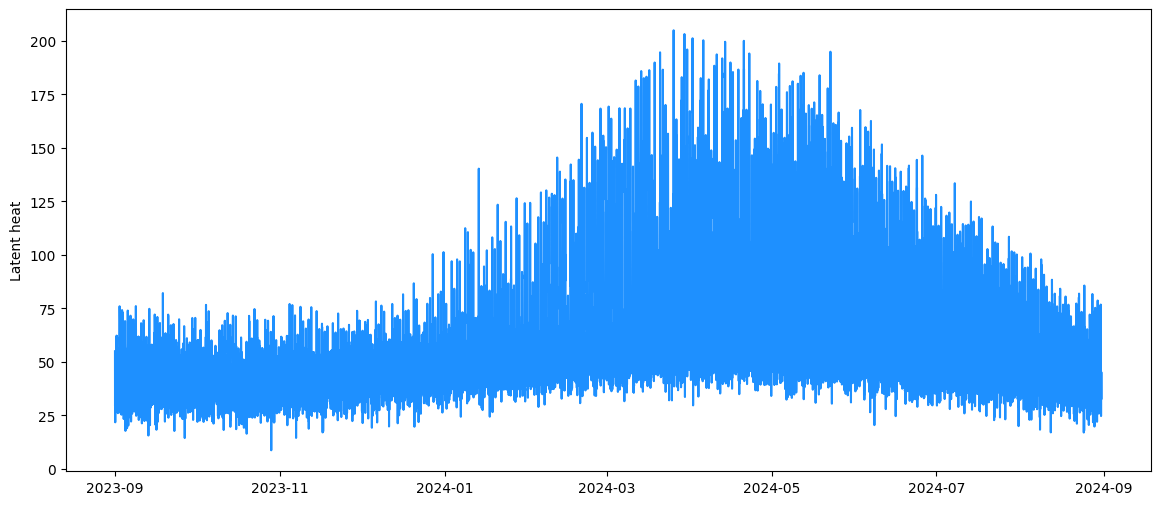

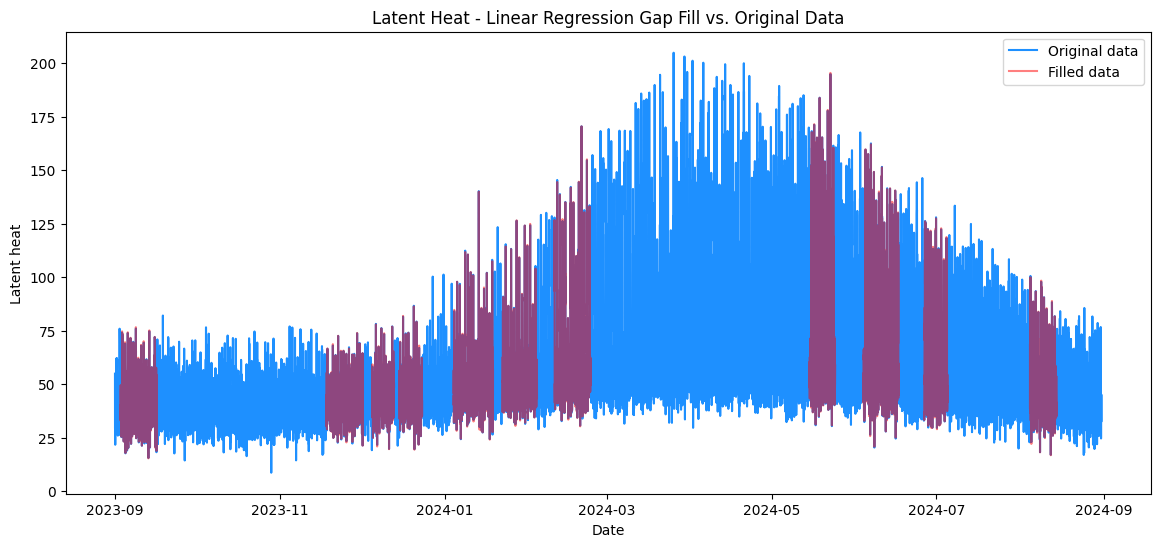

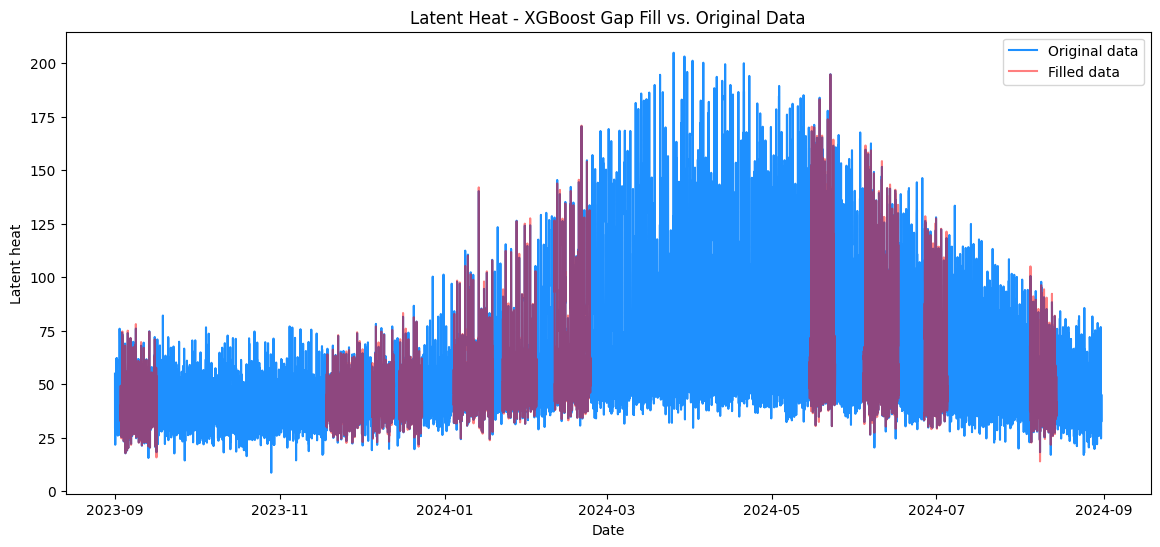

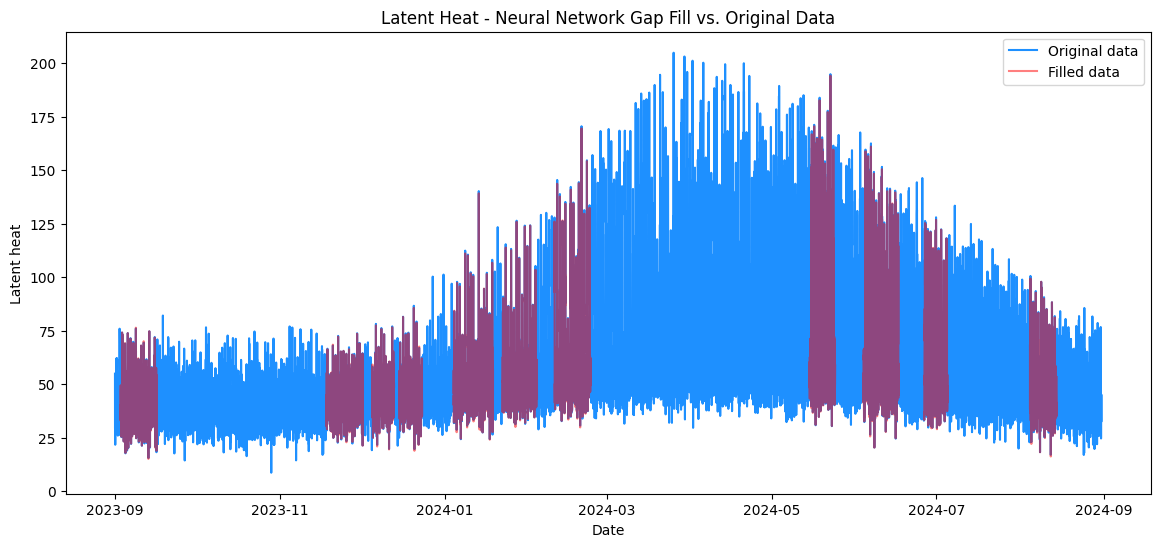

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot original data, gap-filled data, and actual data without gaps for comparison
def plot_filled_data_with_comparison(dataframe, features_df, title):
    plt.figure(figsize=(14, 6))

    # Plot the actual, complete data from features_df in a transparent line
    plt.plot(features_df.index, features_df['latent_heat'], color='dodgerblue', alpha=1, label='Original data')

    # Plot the original (non-gap-filled) data from df
    original_data_mask = df['latent_heat'].notna()
    #plt.plot(df.index[original_data_mask], df['latent_heat'][original_data_mask], color='blue', alpha=0.7, label='Original Data')

    # Identify and plot each gap-filled segment from df in a transparent line
    filled_data_mask = ~original_data_mask  # True where data was filled
    gap_boundaries = np.where(np.diff(filled_data_mask.astype(int)) != 0)[0]
    gap_segments = [(gap_boundaries[i] + 1, gap_boundaries[i + 1] + 1) for i in range(0, len(gap_boundaries) - 1, 2)]

    # Plot each gap-filled segment individually
    for start, end in gap_segments:
        plt.plot(dataframe.index[start:end], dataframe['latent_heat'].iloc[start:end], color='red', linestyle='-', alpha=0.5, label='Filled data')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Plot formatting
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Latent heat')
    plt.show()

# Plotting original data
plt.figure(figsize=(14, 6))
plt.plot(features_df.index, features_df['latent_heat'],label='Original data',color='dodgerblue')
plt.ylabel('Latent heat')

# Plotting each method's result for comparison
plot_filled_data_with_comparison(df_lr, features_df, "Latent Heat - Linear Regression Gap Fill vs. Original Data")
plot_filled_data_with_comparison(df_xgb, features_df, "Latent Heat - XGBoost Gap Fill vs. Original Data")
plot_filled_data_with_comparison(df_nn, features_df, "Latent Heat - Neural Network Gap Fill vs. Original Data")
#plot_filled_data_with_comparison(df_lstm, features_df, "Latent Heat - LSTM Gap Fill vs. Original Data")
